# Data Analysis Plan: Foreign Exchange Analysis

# Team 6
- Mahek Aggarwal
- John Gemmell
- Jacob Kulik
- David Pogrebitskiy


# Project Goal:
This Project aims to use exchangerate.host, a free foreign exchange and crypto API,
to understand how different currencies change and in relation to others and if a movement in
one can help predict a movement in another. By analysing trends and volatility, we will be able
to understand which currencies trigger a global movement, which ones tend to follow afterwards, and
be able to predict a currency's direction if we see a movement in a currency that it tracks.

# Data:
## Overview:

We will request Foreign Exchange values for a variety of different currencies and cryptos
from the ExchangeRate API. Our data will include both major and minor currencies that are pegged to/track
the currencies of first-world countries. Because the data coming from the API is in a time-series format,
we will be able to look at a variety of different period lengths between observations to see
which length best suits our needs.
# Pipeline Overview:
## API and Formating Functions:
- `api_req()`
    - makes an initial request to the API that includes time-series data of all of our
    desired parameters using Python's kwargs feature

- `merge_df_by_year()`
    - Merge multiple years worth of data into one dataframe because the API limits us
    to 2 years of data per call

## Analysis and Visualizations:
- `scale_cur()`
    - scales the currencies to be between 0 and 1, helping with plotting and analyzing
- `moving_avg()`
    - builds a moving function for a certain currency
- `calc_pct_change()`
    - calculating the percentage change between values, helping normalize an analysis

In [1]:
import requests
from pprint import pprint
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler

In [2]:
def api_req(**kwargs):
    '''
    This function calls an exchange rate api and builds a df with the data
    A list of strings (currencies) is a parameter
    returns a transpose dataframe where the dates are the indices

    Params for API call kwargs:
        start_date [required] String format (YYYY-MM-DD)
        end_date [required] String format (YYYY-MM-DD)
        base. example:base=USD
        symbols	[optional] Enter a list of comma-separated currency codes to limit output
            currencies. example:symbols=USD,EUR,CZK
        amount	[optional] The amount to be converted. example:amount=1200
        places	[optional] Round numbers to decimal place. example:places=2
        source	[optional] You can switch source data between (default) forex, bank view or crypto currencies. (ecb, crypto)
    '''

    params = kwargs
    url = 'https://api.exchangerate.host/timeseries?'
    
    # Query the API call
    response = requests.get(url, params=params)
    data = response.json()

    return pd.DataFrame(data['rates']).T

api_req(start_date='2021-01-01', end_date='2022-01-01', base='USD', symbols='USD,GBP,RUB,EUR,XAU,INR,SAR,ZWL')

,EUR,GBP,INR,RUB,SAR,USD,XAU,ZWL
2021-01-01,0.821300,0.731368,73.092243,73.944993,3.751083,1.0,0.000526,321.999969
2021-01-02,0.824063,0.731368,73.092239,73.944989,3.751083,1.0,0.000527,321.999953
2021-01-03,0.817388,0.731935,73.086997,74.108816,3.751574,1.0,0.000529,321.999927
2021-01-04,0.816286,0.736620,73.085430,73.532982,3.751654,1.0,0.000515,321.999924
2021-01-05,0.813219,0.734071,73.141760,74.170118,3.750710,1.0,0.000513,322.000080
...,...,...,...,...,...,...,...,...
2021-12-28,0.884210,0.744312,74.660958,73.642400,3.753391,1.0,0.001307,321.735660
2021-12-29,0.880921,0.741268,74.417699,73.951951,3.751720,1.0,0.001029,321.748905
2021-12-30,0.882704,0.740360,74.349051,74.703970,3.750606,1.0,0.001528,321.639550
2021-12-31,0.879286,0.739386,74.490885,74.767039,3.753574,1.0,0.001239,321.889925


In [3]:
def merge_df_by_years(start_year, end_year, **kwargs):
    '''
    Creates a dataframe containing the exchange rates from the start year to the end year.
    Merge multiple years worth of data into one dataframe from the API call because it limits
    the amount of row in a request.
    :param start_year (int):
    :param end_year (int):
    
    :return: DataFrame
    '''

    df_output = pd.DataFrame()
    
    # Iterate through the the desired years
    for year in range(start_year, end_year + 1):
        params = {
            'start_date': f'{year}-01-01',
            'end_date': f'{year}-12-31',
        }
        # Update the params with the other input params
        kwargs.update(params)
        df_year = api_req(**kwargs)
        
        # Stack all the dataframes because of the API limitting
        df_output = pd.concat([df_output, df_year])
    df_output.dropna(inplace=True, axis=0)
    return df_output

df = merge_df_by_years(2010, 2022, symbols='USD,GBP,RUB,EUR,INR,SAR', base='USD') 
df

,USD,GBP,RUB,INR,EUR,SAR
2010-01-04,1.0,0.620632,30.297421,46.220189,0.693289,3.689961
2010-01-05,1.0,0.625226,29.990185,46.107476,0.696088,3.752610
2010-01-06,1.0,0.623993,29.861427,45.694252,0.694252,3.743682
2010-01-07,1.0,0.627532,29.854658,45.675374,0.698422,3.742492
2010-01-08,1.0,0.620012,29.749011,45.292485,0.693914,3.727986
...,...,...,...,...,...,...
2022-11-07,1.0,0.868213,61.656488,81.710289,0.997693,3.755820
2022-11-08,1.0,0.867338,60.976095,81.405735,0.992693,3.760495
2022-11-09,1.0,0.881096,61.648347,81.391295,0.999186,3.760190
2022-11-10,1.0,0.855595,61.052951,80.473738,0.981028,3.759395


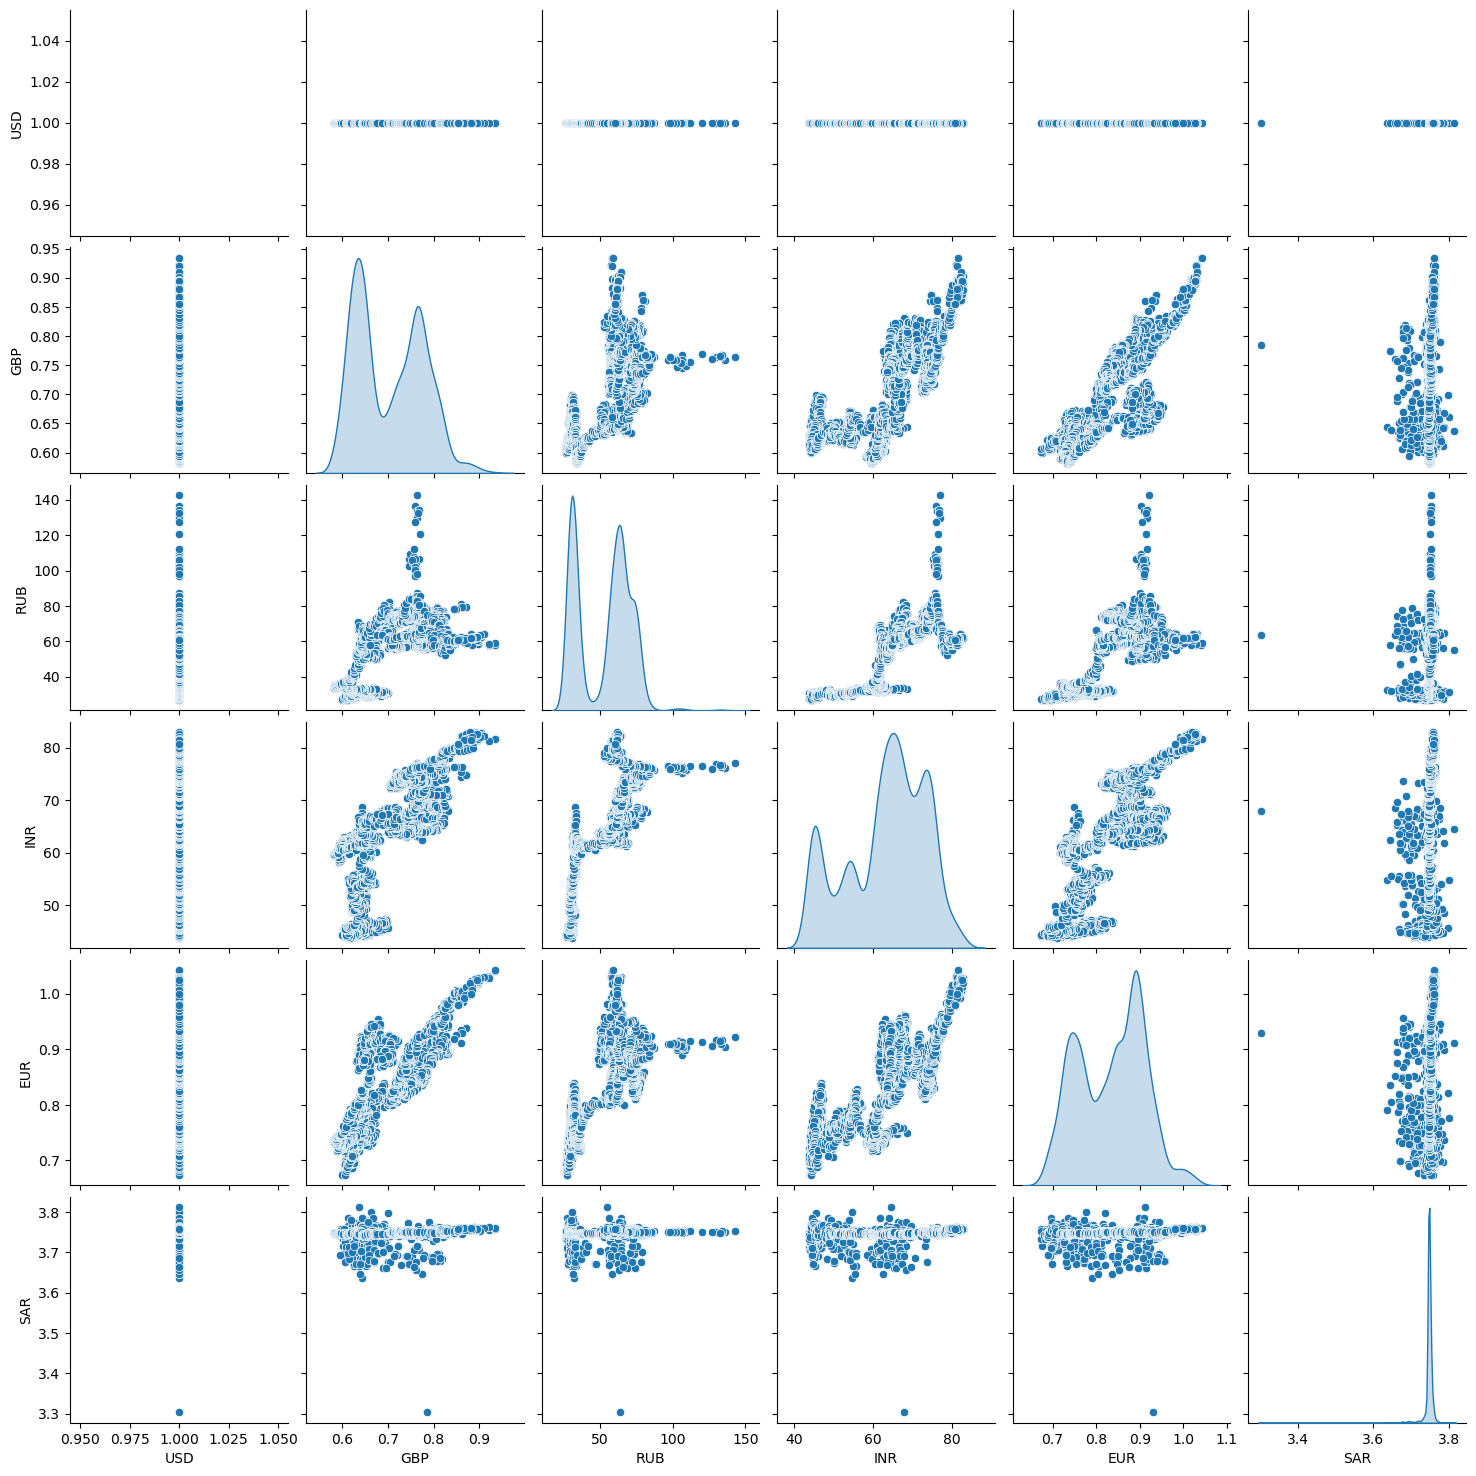

In [4]:
sns.pairplot(df, diag_kind='kde')
plt.show()

In [5]:
def scale_cur(df):
    '''
    Scales the exchange rates for a dataframe of currencies
    df- dataframe
    returns a scaled dataframe
    '''

    cols = df.columns
    # fitting a scaler to make the data comparable visually
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=cols)

    # updating indexes to be dates
    df_scaled.index = df.index
    return df_scaled

df_scaled = scale_cur(df)
df_scaled

,USD,GBP,RUB,INR,EUR,SAR
2010-01-04,0.0,0.107887,0.030892,0.061827,0.053085,0.761210
2010-01-05,0.0,0.120938,0.028243,0.058944,0.060660,0.884409
2010-01-06,0.0,0.117435,0.027132,0.048375,0.055691,0.866852
2010-01-07,0.0,0.127489,0.027074,0.047892,0.066976,0.864512
2010-01-08,0.0,0.106125,0.026163,0.038099,0.054776,0.835986
...,...,...,...,...,...,...
2022-11-07,0.0,0.811244,0.301325,0.969573,0.876865,0.890721
2022-11-08,0.0,0.808758,0.295458,0.961783,0.863334,0.899915
2022-11-09,0.0,0.847843,0.301255,0.961414,0.880905,0.899315
2022-11-10,0.0,0.775397,0.296121,0.937945,0.831766,0.897752


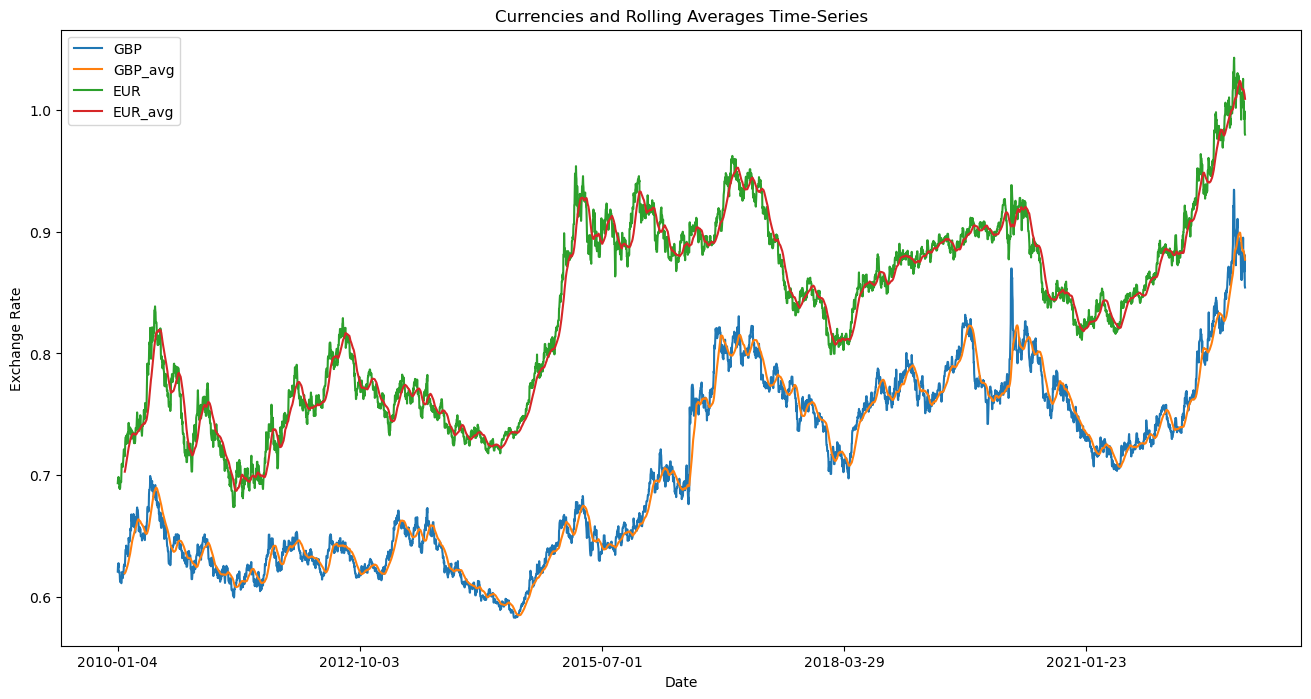

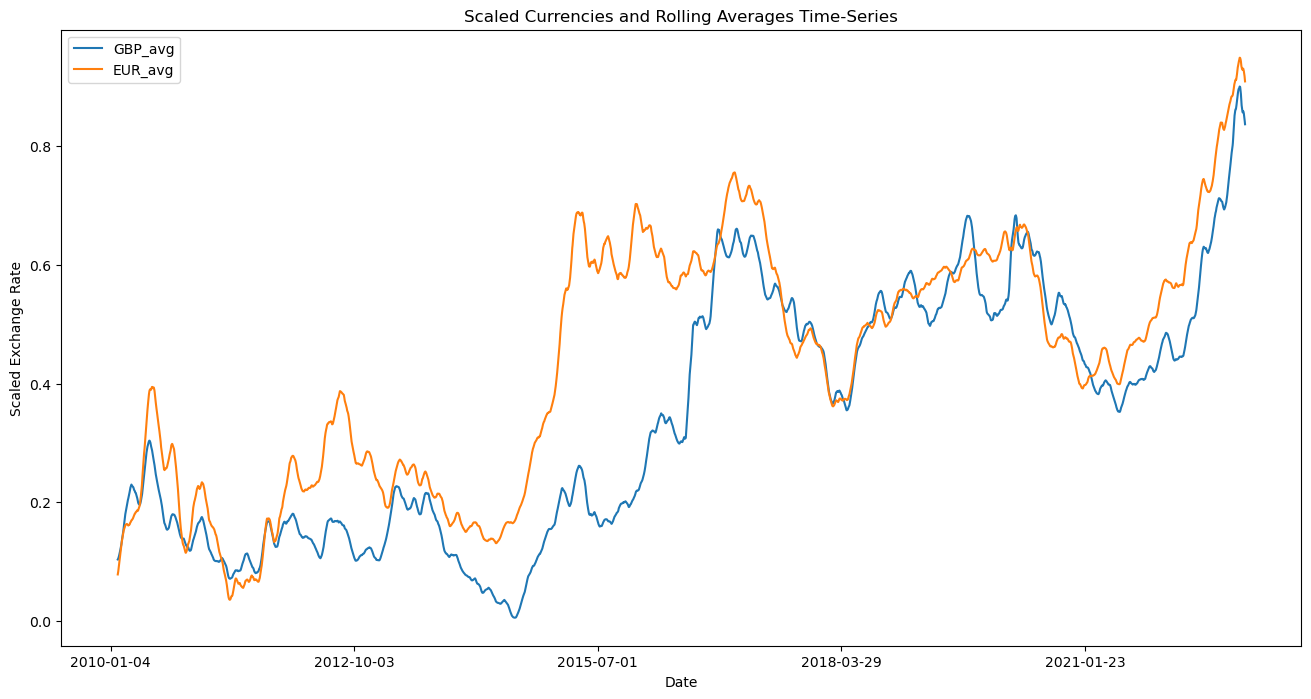

In [6]:
def moving_avg(df, roll, *curs, scale=True):
    '''
    Creates a moving average plot for a given number of currencies and their moving averages
    df - dataframe, roll - int and number of days to be smoothed, *curs - list of currencies
    returns an updated df and a plot
    '''
    fig, ax = plt.subplots()

    # Creating label based off graph type
    plt.xlabel('Date')
    if scale:
        plt.ylabel('Scaled Exchange Rate')
        plt.title('Scaled Currencies and Rolling Averages Time-Series')
    else:
        plt.ylabel('Exchange Rate')
        plt.title('Currencies and Rolling Averages Time-Series')

    # iterating across currencies
    for cur in curs:
        cur_idx = cur + '_avg'
        # creating a rolling mean column and plotting both
        df[cur_idx] = df[cur].rolling(roll).mean()
        if scale:
            df[[cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
        else:
            df[[cur, cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
    return df

df_usd = moving_avg(df, 30,'GBP','EUR', scale=False)
df_usd_scaled = moving_avg(df_scaled, 30, 'GBP', 'EUR', scale=True)
plt.show()

In [7]:
def calc_pct_change(df):
    """
    Calculates the pct change between each observation in the dataframe
    """
    pct_df = df.pct_change()
    
    # Rename each of the columns for the pct change
    for col in pct_df.columns:
        pct_df.rename(columns={col: col+"_pct_change"}, inplace=True)
    
    # Concat the original with pct change df
    return pct_df, pd.concat([df, pct_df], axis=1)

pct_df, pct_concated = calc_pct_change(df)

# Analysis Plan:

* We plan to analyze our time-series data of the currencies using different regression models such as linear regression, polynomial regression, and KNN regression and comparing these models to determine which one yields the best results for a predictive model.

* We can incorporate our scaled exchange rate info to make more sense of currency pegs and the fluctuation of excgange rates

* We can incorporate a cryptocurrency analysis as well, seeing how accurate different models are for crypto

* We also plan on analyzing the seasonality of how these currencies move to potentially see if we can identify any cycles that can help us predict a movement direction.

* Adding on, we can incoroprate more interactive plots, such as plotly dash, to allow a user to interact with our times-series data and play around with certain parameters

* Additionally, the correlation of various currencies can be calculated and analyzed to determine which currencies track with one another 

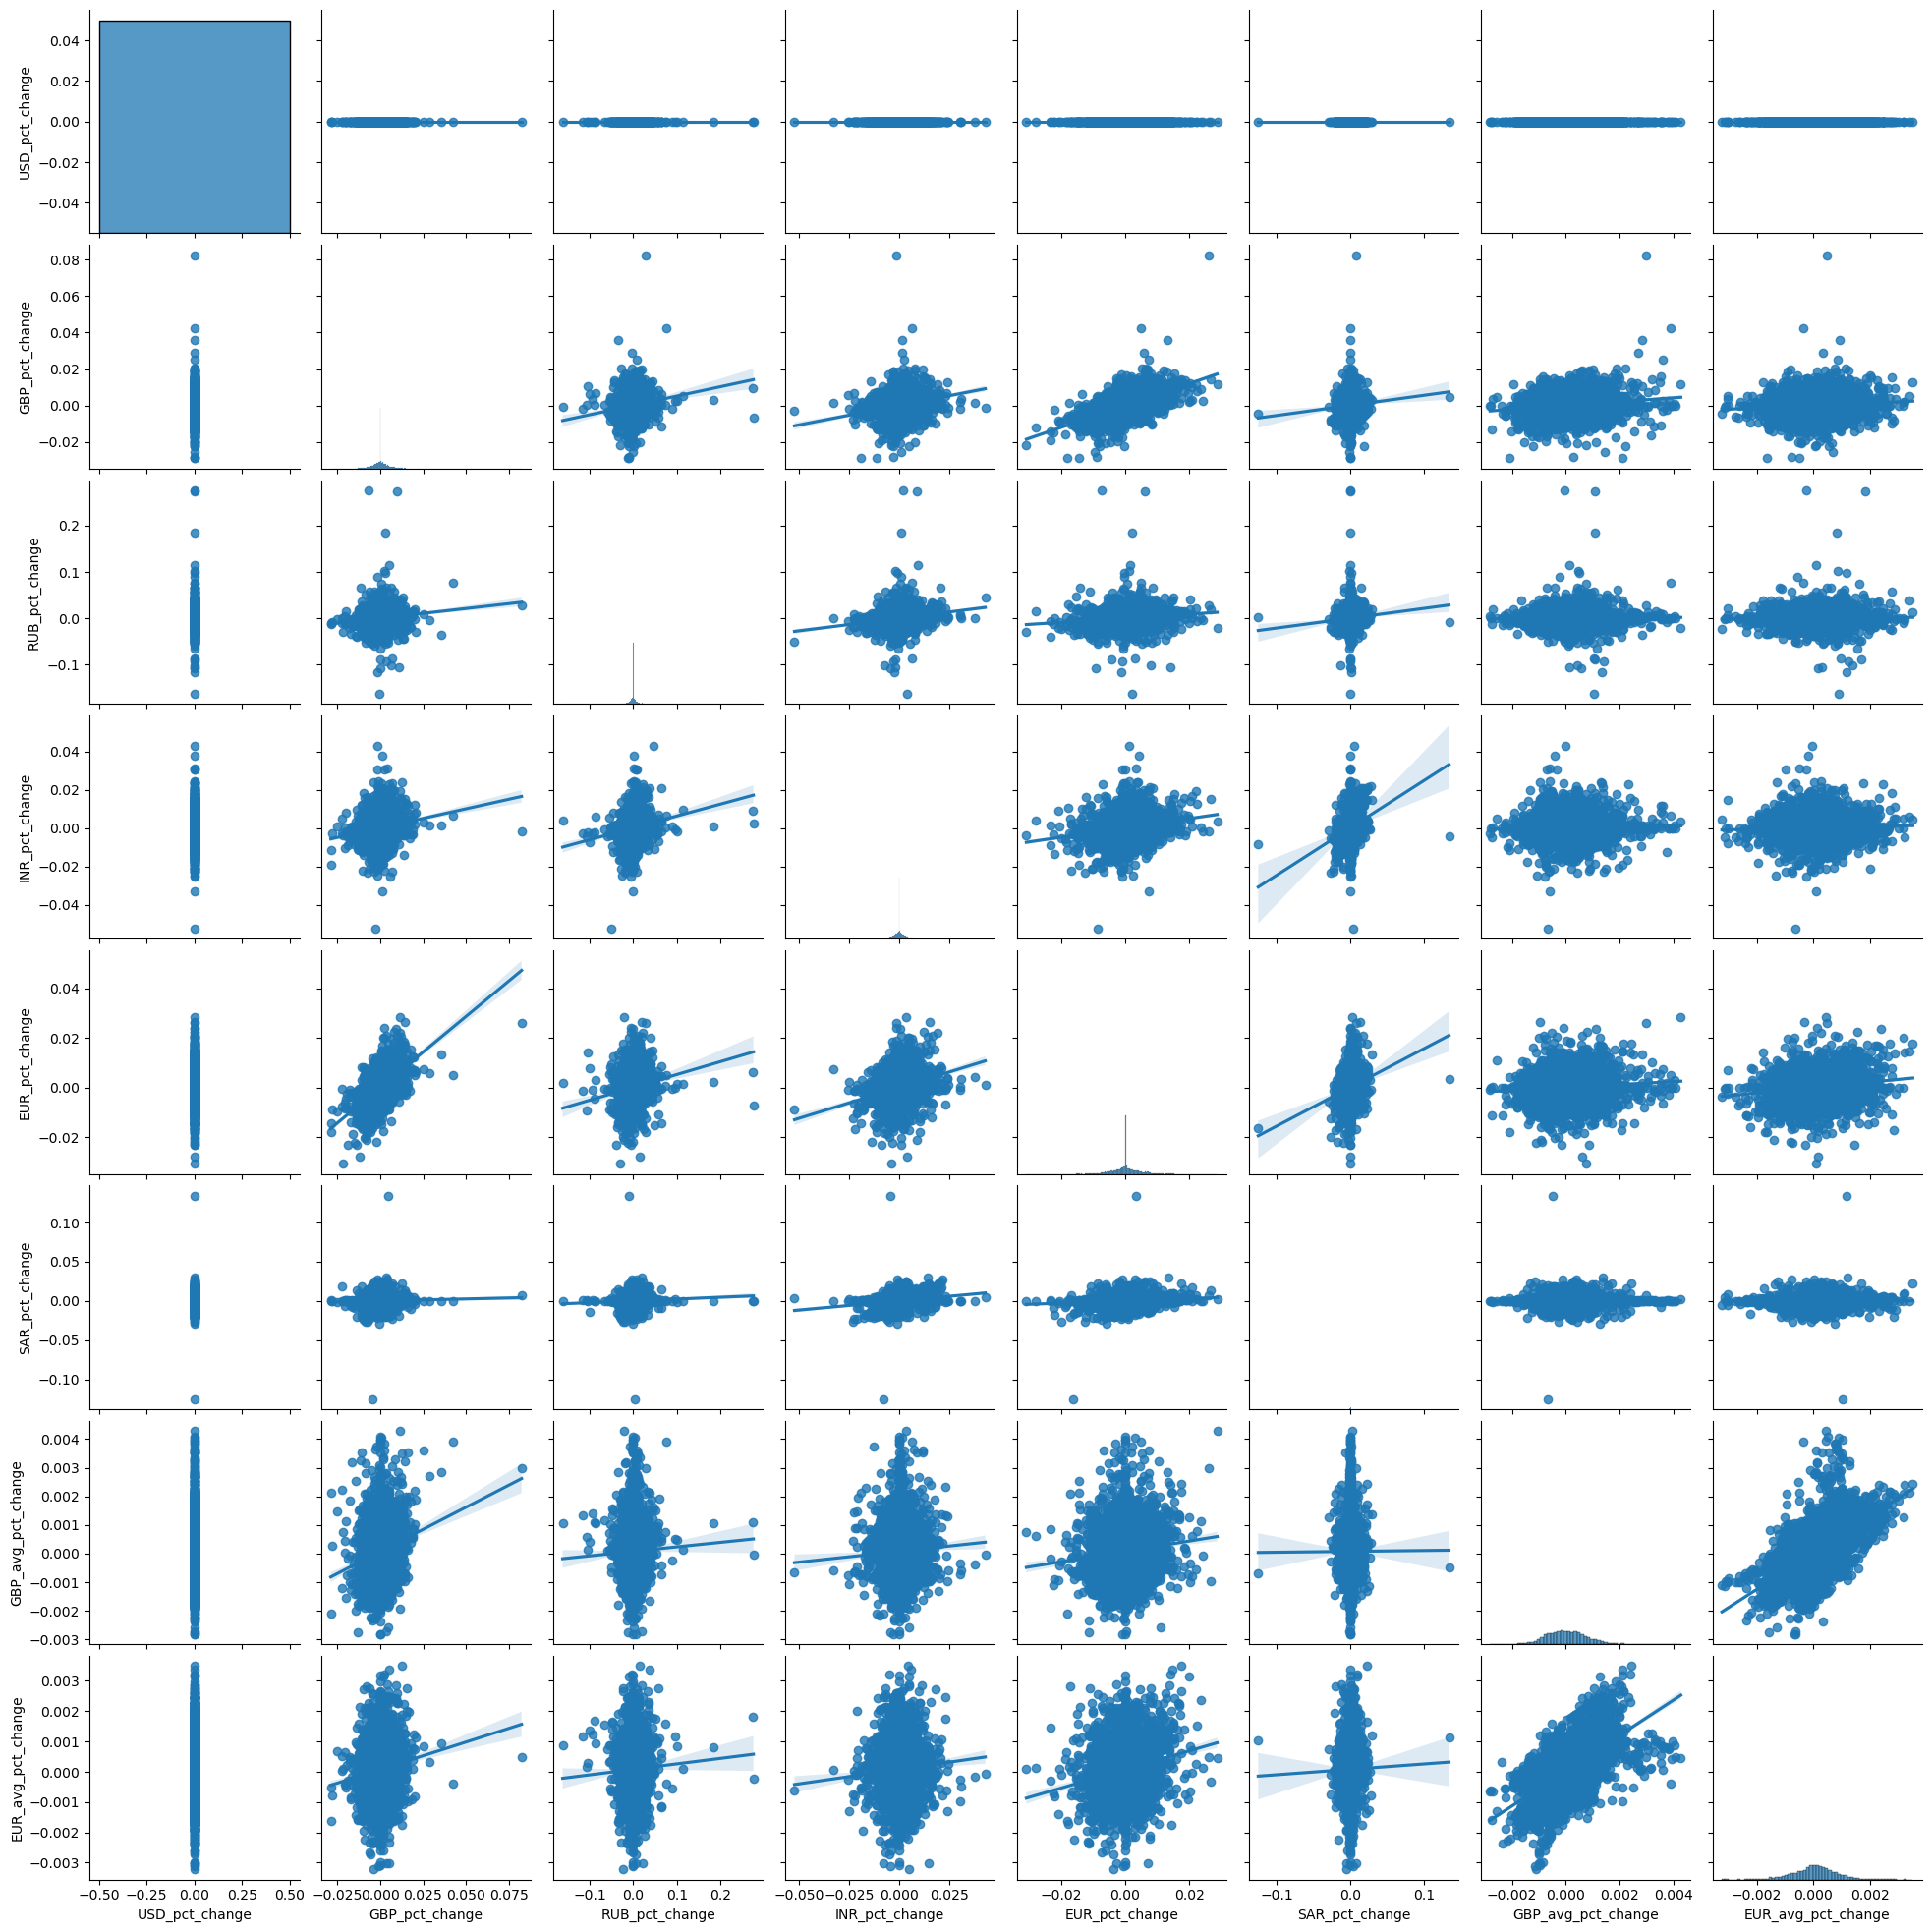

In [14]:
sns.pairplot(pct_df.dropna(axis=0), kind='reg')
plt.show()